# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## BAO theory and broadbands
The BAO broadband can be parameterized as:
- $k$ powers, $\sum_{i} (k / k_{p})^{i}$
- as sum of TSC or PCS kernels, $\sum_{i} K(k / k_{p} - i)$
where typically $k_{p} = 2\pi / r_{s}$.

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


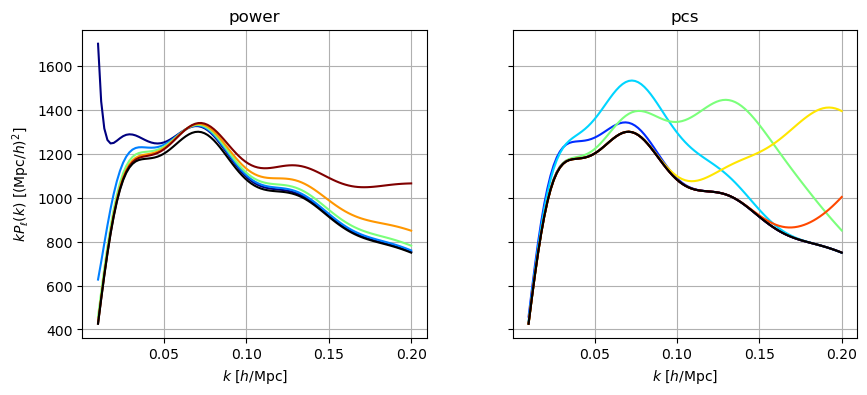

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles

template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template, broadband='power')

from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, broadband in enumerate(['power', 'pcs']):
    ax = lax[iax]
    theory.init.update(broadband=broadband)
    names = theory.all_params.names(basename='*l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 5e2 if broadband == 'power' else 5e3})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(broadband)
plt.show()

## BAO likelihood

In [3]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

theory.init.update(broadband='pcs')
# Set damping sigmas to zero, as data follows linear pk
for param in theory.init.params.select(basename='sigma*'):
    param.update(value=0., fixed=True)
# Analytically solve for broadband parameters (named 'al*_*')
for param in theory.init.params.select(basename='al*_*'):
    param.update(derived='.auto')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

In [4]:
# Note, observable can take as input:
# - data: a (list of) (path to) PowerSpectrumStatistics object, flat array (see example below),
# or dictionary of parameters where to evaluate the theory to take as a mock data vector
# - covariance: a (list of) (path to) mocks, array (covariance matrix), or None (covariance passed to ObservablesGaussianLikelihood instead)

# Example, passing arrays:
ells = (0, 2)
k, pk = data(ell=ells, complex=False, return_k=True) # numpy array
mask = (k > 0.005) & (k < 0.2)
k = k[mask]  # array; one could also provide a list of k arrays, one for each ell
pk = np.ravel([pp[mask] for pp in pk])  # flat array
cov = np.cov([np.ravel([pp[mask] for pp in mock(ell=ells, complex=False)]) for mock in mocks], rowvar=False)  # array
observable = TracerPowerSpectrumMultipolesObservable(data=pk,
                                                     covariance=cov,
                                                     ells=ells,
                                                     k=k,
                                                     shotnoise=shotnoise,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [5]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=3)

[000000.10] [0/1] 10-02 22:43  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].
[000000.67] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000000.69] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


In [6]:
print(profiles.to_stats(tablefmt='pretty'))

+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 17) = 18.53 / 21 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qpar                 |  True  | 1.0023  | 0.0038 |
|                 qper                 |  True  | 0.9979  | 0.0069 |
|                  b1                  |  True  |  1.959  | 0.069  |
|                al0_-1                |  True  |  31000  |        |
|                al0_0                 |  True  |  1800   |        |
|                al0_1                 |  True  |   380   |        |
|                al0_2                 |  True  |   270   |        |
|                al0_3                 |  True  |   55    |        |
|                al0_4                 |  True  |   510   |        |
|                al0_5                 |  True  | -710000 |        |
|                al2_-1                |  True  |  4400   |        |
|                al2_0            

[000016.45] [0/1] 10-02 22:43  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000016.45] [0/1] 10-02 22:43  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000016.51] [0/1] 10-02 22:43  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000016.51] [0/1] 10-02 22:43  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


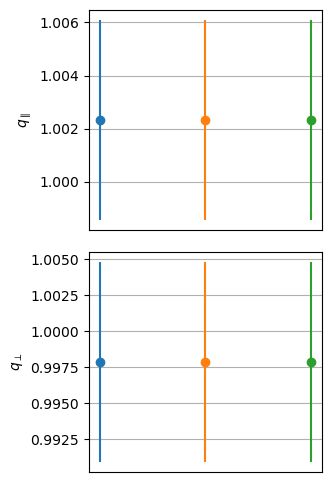

In [7]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper']);

[000016.55] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000016.56] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


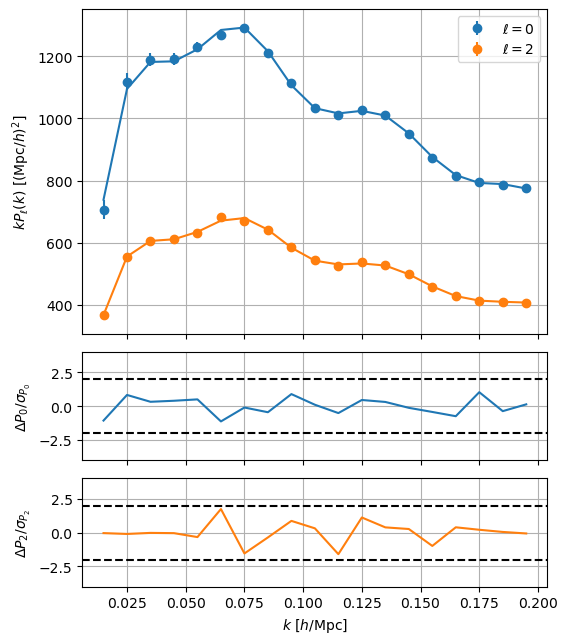

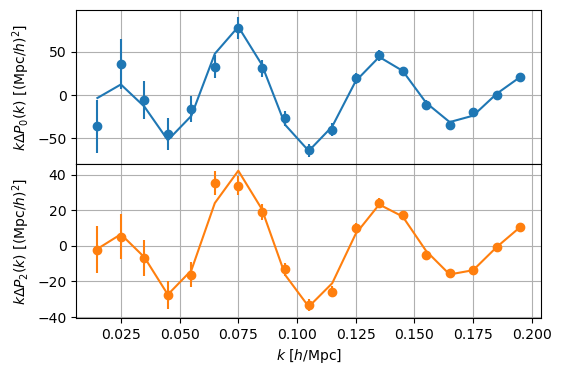

In [8]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot()
observable.plot_wiggles();

## Detection level

In [9]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000018.10] [0/1] 10-02 22:43  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000018.12] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000018.12] [0/1] 10-02 22:43  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


In [10]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000062.12] [0/1] 10-02 22:44  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000062.14] [0/1] 10-02 22:44  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000062.14] [0/1] 10-02 22:44  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
+--------------------------------------+--------+----------+--------+
| chi2 / (38 - 16) = 19.37 / 22 = 0.88 | varied | bestfit  | error  |
+--------------------------------------+--------+----------+--------+
|                 qiso                 |  True  |  1.0036  | 0.0036 |
|                  b1                  |  True  |  1.949   | 0.069  |
|                al0_-1                |  True  |  32000   |        |
|                al0_0                 |  True  |

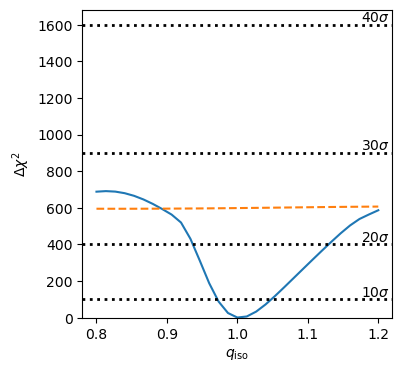

In [11]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40]);

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [12]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

[000112.78] [0/1] 10-02 22:45  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[000230.84] [0/1] 10-02 22:47  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000230.86] [0/1] 10-02 22:47  EmceeSampler              INFO     Diagnostics:
[000230.86] [0/1] 10-02 22:47  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0752; not < 0.05.
[000230.87] [0/1] 10-02 22:47  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0656.
[000230.97] [0/1] 10-02 22:47  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.297.
[000230.98] [0/1] 10-02 22:47  EmceeSampler              INFO     - max Geweke is 0.321.
[000230.98] [0/1] 10-02 22:47  EmceeSampler              INFO     - Geweke p-value is 0.642.
[000230.99] [0/1] 10-02 22:47  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 13.3.


/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000355.02] [0/1] 10-02 22:49  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000355.04] [0/1] 10-02 22:49  EmceeSampler              INFO     Diagnostics:
[000355.05] [0/1] 10-02 22:49  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0858; not < 0.05.
[000355.06] [0/1] 10-02 22:49  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0775.
[000355.27] [0/1] 10-02 22:49  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.218.
[000355.28] [0/1] 10-02 22:49  EmceeSampler              INFO     - max Geweke is 0.483.
[000355.28] [0/1] 10-02 22:49  EmceeSampler              INFO     - Geweke p-value is 0.652.
[000355.29] [0/1] 10-02 22:49  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 16.3.
[000355.29] [0/1] 10-02 22:49  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.39.
[000488.91] [0/1] 10-02 22:51  Chain           

[Chain(shape=(2100, 6), params=ParameterCollection(['qiso', 'b1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5']))]

In [13]:
chain = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+--------+---------+---------+---------+--------+-----------------+-----------------+
|        | argmax  |  mean   | median  |  std   | quantile:1sigma | interval:1sigma |
+--------+---------+---------+---------+--------+-----------------+-----------------+
|  qiso  | 1.0036  | 1.0036  | 1.0036  | 0.0036 | -0.0037/+0.0038 | -0.0044/+0.0031 |
|   b1   |  1.949  |  1.938  |  1.934  | 0.067  |  -0.070/+0.066  |  -0.078/+0.057  |
| al0_-1 |  3.2e4  |  3.3e4  |  3.3e4  | 24000  |  -24000/+25000  |  -24000/+24000  |
| al0_0  |  2200   |  2700   |  2800   |  3200  |   -3200/+3200   |   -2900/+3500   |
| al0_1  |   380   |   490   |   540   |  810   |    -810/+810    |    -690/+920    |
| al0_2  |   310   |   380   |   400   |  450   |    -460/+460    |    -400/+510    |
| al0_3  |   10    |   20    |   30    |  190   |    -190/+190    |    -180/+200    |
| al0_4  |   840   |   910   |   930   |  780   |    -770/+780    |    -790/+780    |
| al0_5  | -1.18e6 | -1.21e6 | -1.21e6 | 930000 | -920

Removed no burn in


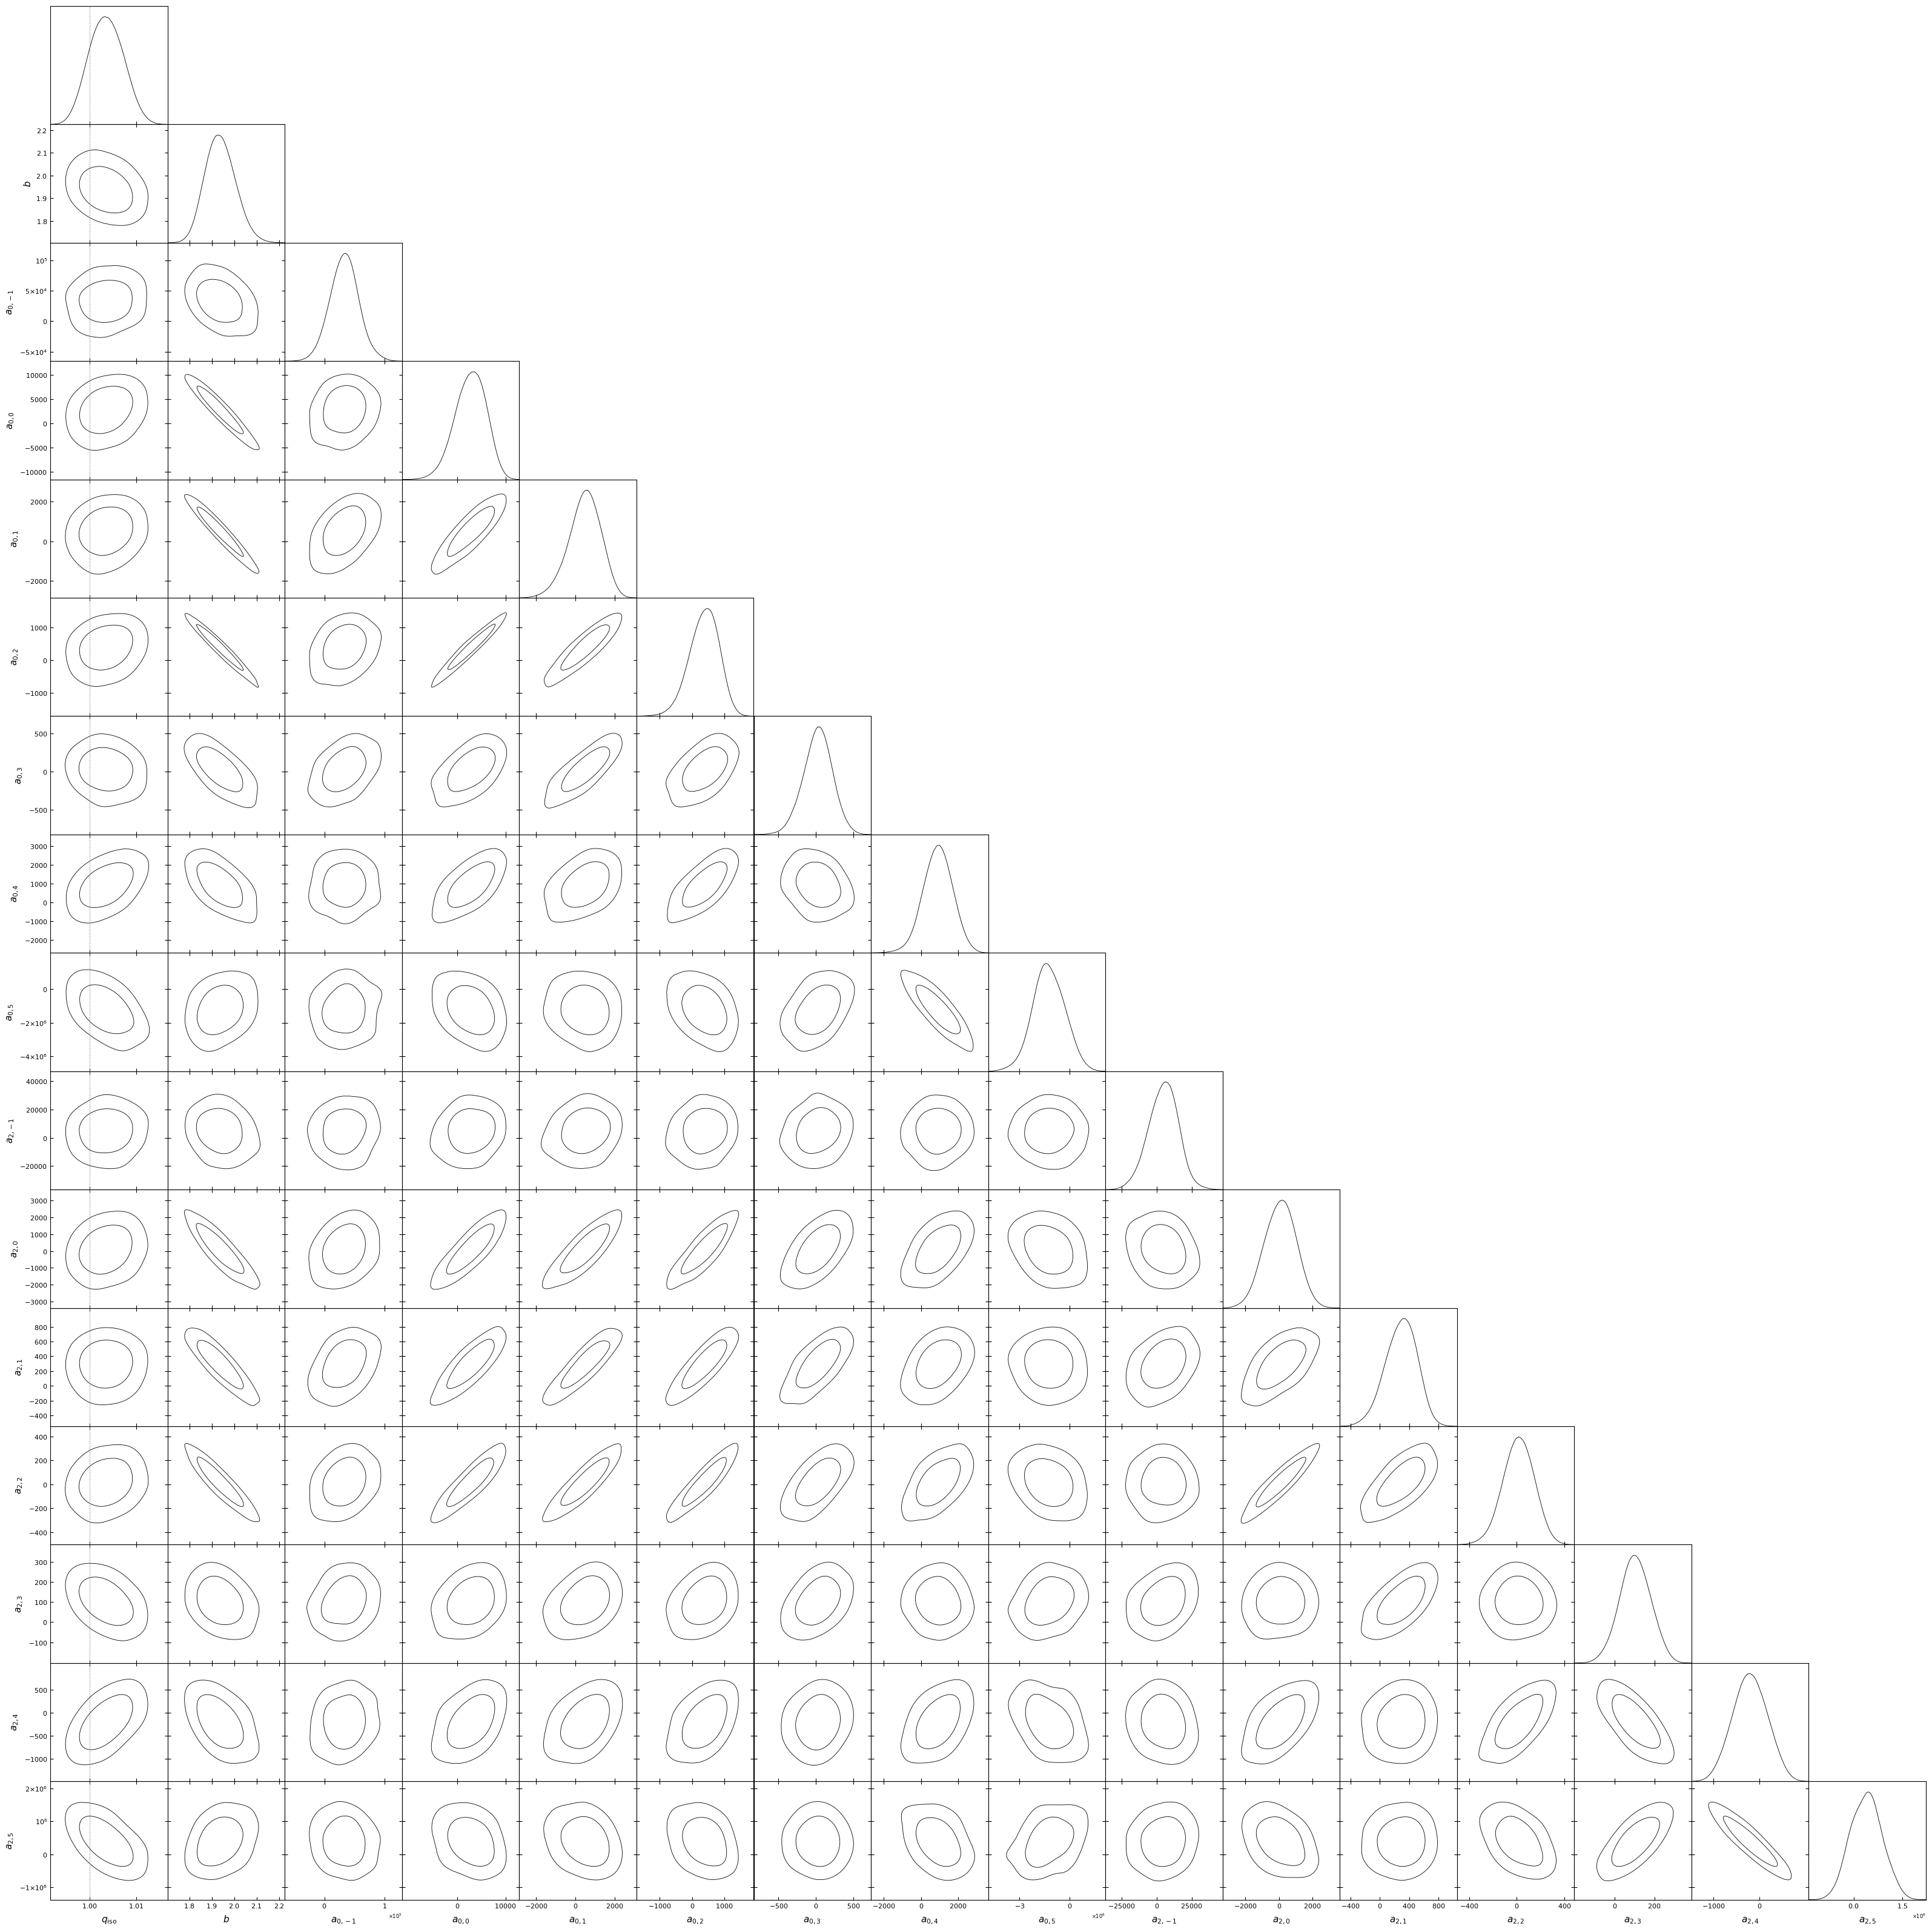

In [14]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})

## Post-processing
Let's use this BAO measurement to put constraints on $\Omega_{m}$.

In [15]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=['qiso'], fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

In [16]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.02})

[001037.22] [0/1] 10-02 23:00  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[001037.29] [0/1] 10-02 23:00  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[001096.95] [0/1] 10-02 23:01  EmceeSampler              INFO     Diagnostics:
[001096.96] [0/1] 10-02 23:01  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0144; < 0.02.
[001096.96] [0/1] 10-02 23:01  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0144.
[001097.00] [0/1] 10-02 23:01  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.103.
[001097.01] [0/1] 10-02 23:01  EmceeSampler              INFO     - max Geweke is 0.911.
[001097.01] [0/1] 10-02 23:01  EmceeSampler              INFO     - Geweke p-value is nan.
[001097.01] [0/1] 10-02 23:01  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 24.1.
[001140.15] [0/1] 10-02 23:02  EmceeSampler              INFO     Error "CosmologyInp

/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py:186: UserWarning: loglikelihood is NaN for {'Omega_m': ParameterArray(Omega_m, None, [0.47884272])}
  warnings.warn('{} is NaN for {}'.format(name, {k: v[mask] for k, v in points.items()}))


[001469.01] [0/1] 10-02 23:08  EmceeSampler              INFO     Diagnostics:
[001469.02] [0/1] 10-02 23:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0324; not < 0.02.
[001469.02] [0/1] 10-02 23:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0324.
[001469.04] [0/1] 10-02 23:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.134.
[001469.04] [0/1] 10-02 23:08  EmceeSampler              INFO     - max Geweke is 0.384.
[001469.04] [0/1] 10-02 23:08  EmceeSampler              INFO     - Geweke p-value is nan.
[001469.05] [0/1] 10-02 23:08  EmceeSampler              INFO     - (1050 iterations / integrated autocorrelation time) is 40.5.
[001469.05] [0/1] 10-02 23:08  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0116.
[001533.90] [0/1] 10-02 23:09  EmceeSampler              INFO     Diagnostics:
[001533.90] [0/1] 10-02 23:09  EmceeSampler              INFO   

[Chain(shape=(4200, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

Removed no burn in


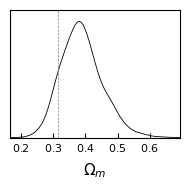

In [17]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})